In [1]:
import numpy as np
import jax.random as rnd
import jax.numpy as jnp
from pylab import *
from flax import nnx
import jax
import optax
from universal_inverter.activations import ReplicationActivation,PiecewiseLinear,AverageSpeedReplication,ConstantSpeedReplication
from universal_inverter.synthetic_data import PiecewiseLinearSimulator


In [2]:


def generate_piecewise_linear_rep(self):
    """Generate piecewise linear signal with specified constraints"""

    coarse_bins = np.random.randint(1,4)
    layer = ConstantSpeedReplication(
    coarse_bins=coarse_bins,
    xmin=0.0,
    xmax=1.0,
    speed=0.015,
    lambda_param=50)
    inputs = (2*np.random.rand(1, coarse_bins ,2)-1)*4

    inputs = jnp.array(inputs)
    fine_grid =  jnp.linspace(0, 1, self.signal_length)[None,:]

    # Adjust minimum to be between -10 and 20
    signal = np.array(layer(inputs,fine_grid))[0]  # Shape: (8, 1024)

    min_val = np.random.uniform(-10, 20)
    signal += (min_val - signal.min())

    return signal.astype(np.float32)
PiecewiseLinearSimulator.generate_piecewise_linear= generate_piecewise_linear_rep

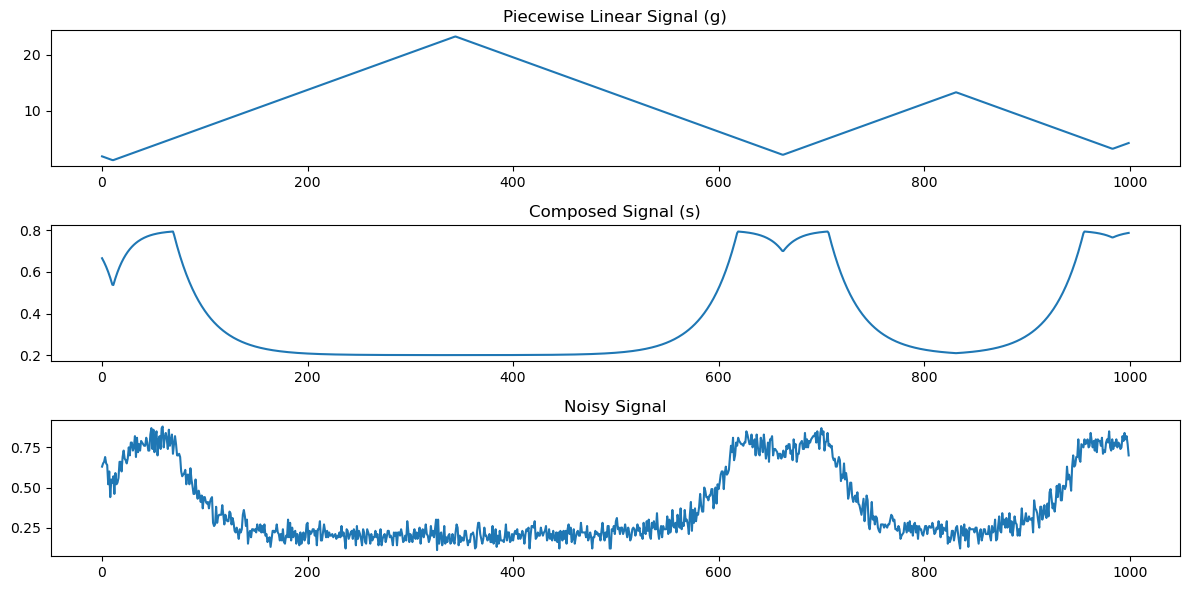

In [3]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt



# Example usage
    # Initialize simulator and dataset
signal_length = 1000
simulator = PiecewiseLinearSimulator(signal_length=signal_length)
#simulator.generate_piecewise_linear = generate_piecewise_linear_rep

# Visualize samples
sample = simulator.generate_sample(delta=0.2)
plt.figure(figsize=(12, 6))

plt.subplot(311)
plt.title("Piecewise Linear Signal (g)")
plt.plot(sample['g'])

plt.subplot(312)
plt.title("Composed Signal (s)")
plt.plot(sample['s'])

plt.subplot(313)
plt.title("Noisy Signal")
plt.plot(sample['noisy_s'])

plt.tight_layout()
plt.show()


In [4]:
class SyntheticSignalDataset(Dataset):
    def __init__(self, simulator, num_samples=1000,delta=0.3):
        self.simulator = simulator
        self.num_samples = num_samples
        self.delta = delta

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):

        sample = self.simulator.generate_sample(delta=self.delta)


        return (
            np.arange(0,1,1/self.simulator.signal_length),
            sample['noisy_s'],  # Input: noisy signal
            sample['g']        # Target: piecewise linear
        )



(1000,)

In [117]:
from universal_inverter.synthetic_data import compute_s
from functools import partial
class MLP(nnx.Module):
    def __init__(self, din: int, hidden_dim: int, coarse_bins: int, *, rngs: nnx.Rngs):
        
        self.coarse_bins = coarse_bins
        self.linear1 = nnx.Linear(din, hidden_dim, rngs=rngs)
        self.linear2 = nnx.Linear(hidden_dim, coarse_bins * 2, rngs=rngs)

    def __call__(self, x: jax.Array):
        x = nnx.relu(self.linear1(x))
        return self.linear2(x).reshape(-1,self.coarse_bins,2)
    
class CMLP(nnx.Module):
    def __init__(self, din: int, hidden_dim: int, coarse_bins: int,replication: bool, *, rngs: nnx.Rngs):
        self.coarse_bins = coarse_bins
        
        # 1D Convolutional Layer
        n_features = 20
        self.replication=replication

        self.conv1 = nnx.ConvTranspose(in_features=1, 
                                       out_features=n_features, 
                                       kernel_size=(3,),
                                       padding='SAME', 
                                       rngs=rngs)
        
        # New: Average Pooling Layer (reduce 1000 → 100 bins)

        self.avg_pool = partial(nnx.avg_pool, window_shape=(2, ), strides=(2,))
        
        self.conv2 = nnx.ConvTranspose(in_features=n_features, 
                                       out_features=n_features, 
                                       kernel_size=(3,),
                                       padding='SAME', 
                                       rngs=rngs)
        self.avg_pool2 = partial(nnx.avg_pool, window_shape=(2, ), strides=(2,))

        conv_out_dim = 250 * n_features
        
        self.linear1 = nnx.Linear(conv_out_dim, hidden_dim, rngs=rngs)
        if replication:
            self.linear2 = nnx.Linear(hidden_dim, coarse_bins * 3, rngs=rngs)
        else:
            self.linear2 = nnx.Linear(hidden_dim, coarse_bins * 2, rngs=rngs)


    def __call__(self, x: jax.Array):
        # Reshape input to (batch, length, channels)
        x = jnp.expand_dims(x, axis=-1)  # (batch, 1000, 1)
        
        # Apply Convolution and ReLU
        x = nnx.relu(self.conv1(x))      # (batch, 1000, 32)
        
        # Apply Average Pooling to reduce to 100 bins (1000 → 100)
        x = self.avg_pool(x)  
        # (batch, 100, 32)
        x = nnx.relu(self.conv2(x))      # (batch, 1000, 32)
        
        # Apply Average Pooling to reduce to 100 bins (1000 → 100)
        x = self.avg_pool2(x) 
        
        # Flatten for dense layers
        x = x.reshape(x.shape[0], -1)    # (batch, 100 × 32 = 3200)
        
        x = nnx.relu(self.linear1(x))
        if self.replication:
            return self.linear2(x).reshape(-1, self.coarse_bins, 3)
        else:
            return self.linear2(x).reshape(-1, self.coarse_bins, 2)


class Model(nnx.Module):

    def __init__(self, din: int, hidden_dim: int = 512, coarse_bins: int = 32,replication=False, *, rngs: nnx.Rngs):
        
        self.coarse_bins=coarse_bins
        self.mlp = CMLP(din,hidden_dim, self.coarse_bins,replication=replication,rngs=rngs)
        self.replication = replication
        if replication:
            self.activation_layer = AverageSpeedReplication(self.coarse_bins, xmin=0, xmax=1,lambda_param=5)
        else:
            self.activation_layer = PiecewiseLinear(self.coarse_bins, xmin=0, xmax=1,activation=False)


    def __call__(self, y_batch, x_eval_batch):
        # y_batch shape: (batch, num_points)
        # x_eval_batch shape: (batch, eval_points)
        params = self.mlp(y_batch)  # (batch, coarse_bins, 3)
        #print(params.shape,x_eval_batch.shape)
        #print(params.shape)
        #print(x_eval_batch.shape)
        # Evaluate each function's control points at corresponding x_eval
        x = self.activation_layer.coarse_positions(params)
        y = params[..., 1]
        if self.replication:
            #speed = jnp.mean(params[...,2],axis=1)
            #speed = jnp.expand_dims(speed, axis=-1) 
            params = params.at[..., 2].set(2* nnx.sigmoid(params[..., 2]) + 0.01)
            #print(jnp.mean(params[...,2]))
            #print(speed.shape,params[...,:2].shape)
           
            return {"activation":self.activation_layer(params, x_eval_batch)}
        else:
            x = self.activation_layer.coarse_positions(params)
            y = params[..., 1]
            return {"activation":self.activation_layer(params, x_eval_batch),"x":x,"y":y}


model = Model(1000,hidden_dim=500,coarse_bins=20,replication=False,rngs=nnx.Rngs(2))
#model = Model(1000,hidden_dim=500,coarse_bins=32,replication=True,rngs=nnx.Rngs(2))

#batch = (jnp.array(batch[0]),jnp.array(batch[1]),jnp.array(batch[2]))
#decode = model(batch[1],batch[0])

In [12]:
y_batch, x_eval_batch = batch[1],batch[0]
# y_batch shape: (batch, num_points)
# x_eval_batch shape: (batch, eval_points)
params = model.mlp(y_batch)  # (batch, coarse_bins, 3)
#print(params.shape,x_eval_batch.shape)
#print(params.shape)
#print(x_eval_batch.shape)
# Evaluate each function's control points at corresponding x_eval
speed = jnp.mean(params[...,2],axis=1)
speed = jnp.expand_dims(speed, axis=-1) 
print(speed.shape,params[...,:2].shape,x_eval_batch.shape,y_batch.shape)

(8, 1) (8, 8, 2) (8, 1000) (8, 1000)


In [101]:
import jax
import jax.numpy as jnp
from functools import partial
import jax
import jax.numpy as jnp

@jax.jit
def l1_second_derivative_loss_breaks(x_c: jnp.ndarray, y_c: jnp.ndarray, weight: float = 1.0) -> jnp.ndarray:
    """
    Compute the L1 loss of the second derivative for a piecewise linear signal 
    defined by breakpoints `(x_c, y_c)`.

    Args:
        x_c: Breakpoint x-coordinates, shape `(batch, num_points)`. Must be sorted along `num_points`.
        y_c: Breakpoint y-coordinates, shape `(batch, num_points)`.
        weight: Scaling factor for the loss term.

    Returns:
        L1 loss scalar (sum of absolute slope changes at breakpoints).
    """
    # Compute slopes between consecutive breakpoints
    delta_x = x_c[:, 1:] - x_c[:, :-1]  # Shape: (batch, num_points - 1)
    delta_y = y_c[:, 1:] - y_c[:, :-1]
    slopes = delta_y / delta_x  # Shape: (batch, num_points - 1)

    # Compute differences between consecutive slopes (second derivative proxy)
    diff_slopes = slopes[:, 1:] - slopes[:, :-1]  # Shape: (batch, num_points - 2)

    # Sum absolute values of slope changes and apply weight
    l1_loss = weight * jnp.mean(jnp.abs(diff_slopes))
    
    return l1_loss


def compute_second_derivative(x: jnp.ndarray) -> jnp.ndarray:
    x_expanded = jnp.expand_dims(x, axis=-1)
    
    # Second derivative kernel [1, -2, 1] (shape: [kernel_length, in_channels, out_channels])
    kernel = jnp.array([1.0, -2.0, 1.0], dtype=x.dtype).reshape(3, 1, 1)
    
    # Compute second derivatives via 1D convolution
    second_deriv = jax.lax.conv_general_dilated(
        lhs=x_expanded,
        rhs=kernel,
        window_strides=(1,),
        padding="SAME",
        dimension_numbers=("NHC", "HIO", "NHC"),  # (batch, spatial, channels)
    )
    return second_deriv
    
@jax.jit
def l1_second_derivative_loss(x: jnp.ndarray, weight: float = 1.0) -> jnp.ndarray:
    """
    Compute the L1 loss of the second derivative of a batch of 1D signals.
    
    Args:
        x: Input tensor of shape `(batch, size)`.
        weight: Scaling factor for the loss term.
    
    Returns:
        L1 loss scalar (mean absolute value of second derivatives).
    """
    # Add a channel dimension for convolution: (batch, size, 1)
   
    
    # Remove channel dimension and compute L1 loss
    second_deriv = compute_second_derivative(x)
    absd = jnp.abs(second_deriv.squeeze(axis=-1))
    #absd = jnp.where(absd<0.01,absd,0) #only penalise small gradient
    l1_loss = weight * jnp.mean(absd)
    
    return l1_loss

#from jax.scipy.special import log_cosh

@jax.jit
def log_cosh_fun(x):
    sgn_x = -2 * jnp.signbit(x.real) + 1
    x = x * sgn_x
    return x + jnp.log1p(jnp.exp(-2.0 * x)) - jnp.log(2.0)

@jax.jit
def transform(decode):
    return compute_s(decode,tau=1.0, tau2=2, b=.8, d=0.2,change_point=5)
@partial(nnx.jit,static_argnums=(2,))
def loss_fn(model: Model, batch, logcosh=False):
    res = model(batch[1],batch[0])
    
        
    decode = res["activation"]
        
    #print(decode.shape)
    #print(batch[2].shape)
    weight = jnp.zeros_like(batch[1]) + 1
    #weight = jnp.where(batch[1]<0.05,weight,1.)  # set weight of 0.2 to zero zones for the linear prediction
    
    #loss = jnp.mean(weight * (decode - batch[2]) ** 2) / 100
    #loss = l1_second_derivative_loss_breaks(res["x"],res["y"],0.001)
    #loss = l1_second_derivative_loss(decode,100)

    loss = jnp.mean((transform(decode) - batch[1]) ** 2)  
    if logcosh:
        loss += 0.5*jnp.mean(weight * log_cosh_fun(decode - batch[2])) / 100
    else:
        loss += 0.5*jnp.mean(weight * (decode - batch[2])**2) / 100

    if "speed" in decode:
        speed = res["speed"]
        loss+= jnp.mean((speed -1)**2)
    #jax.debug.print("{loss}",loss=loss)
    return loss


@partial(nnx.jit,static_argnames=["logcosh"])
def train_step(
    model: nnx.Module,
    optimizer: nnx.Optimizer,
    metrics: nnx.MultiMetric,
    batch,
    logcosh: bool = False,
    max_norm: float = .05,  # Add max_norm parameter
):
    #"Train for a single step with gradient clipping."
    grad_fn = nnx.value_and_grad(lambda x,y :loss_fn(x,y,logcosh))
    loss, grads = grad_fn(model, batch)
    
    # Compute global gradient norm
    grads_squared = jax.tree_util.tree_map(lambda g: jnp.sum(jnp.square(g)), grads)
    total_squared = jax.tree_util.tree_reduce(lambda a, b: a + b, grads_squared)
    global_norm = jnp.sqrt(total_squared)
    
    # Calculate scale factor for clipping
    scale = max_norm / (global_norm + 1e-6)
    scale = jnp.minimum(scale, 1.0)
    
    # Apply gradient clipping
    clipped_grads = jax.tree_util.tree_map(lambda g: g * scale, grads)
    
    metrics.update(loss=loss)
    optimizer.update(clipped_grads)  # Use clipped gradients
"""
@nnx.jit
def train_step(model: Model, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch):
    #"Train for a single step."
    grad_fn = nnx.value_and_grad(loss_fn)#, has_aux=False)
    loss, grads = grad_fn(model, batch)
    metrics.update(loss=loss)  # In-place updates.
    optimizer.update(grads)  # In-place updates.
"""

@partial(nnx.jit,static_argnames=["logcosh"])
def eval_step(model: Model, metrics: nnx.MultiMetric, batch,logcosh: bool = False):
    loss = loss_fn(model, batch,logcosh)
    metrics.update(loss=loss)  # In-place updates
    




metrics = nnx.MultiMetric(
  #accuracy=nnx.metrics.Accuracy(),
  loss=nnx.metrics.Average('loss'),
)

#nnx.display(optimizer)

In [68]:
[0,1,2][:2]

[0, 1]

In [54]:
jnp.array(batch[0]).shape

(8, 1000)

[[-0.05116595 -0.05206734 -0.05296873 ... -0.14605348 -0.14515205
  -0.14425068]
 [ 0.16148047  0.16056903  0.15965758 ...  0.21688956  0.217801
   0.2187125 ]
 [-0.21803266 -0.21892907 -0.21982557 ... -0.19310802 -0.19221154
  -0.19131508]
 ...
 [ 0.02089286  0.01998813  0.0190834  ... -0.15029517 -0.1493904
  -0.14848566]
 [-0.29918492 -0.30007878 -0.30097258 ... -0.1850468  -0.18415293
  -0.18325911]
 [-0.04952504 -0.05042301 -0.05132098 ... -0.00055641  0.00034161
   0.00123958]]


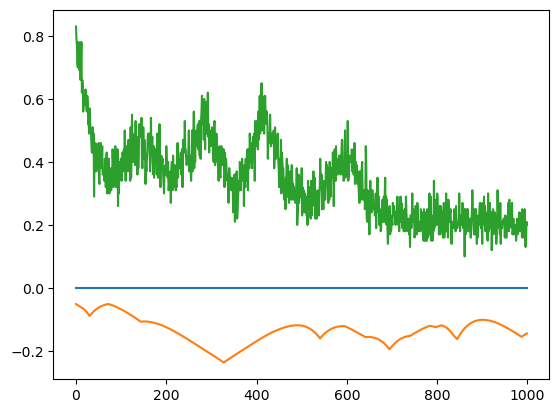

In [18]:
batch = (jnp.array(batch[0]),jnp.array(batch[1]),jnp.array(batch[2]))
decode = model(batch[1],batch[0])["activation"]
print(decode)
trns = compute_s(decode,tau=1.0, tau2=2, b=.8, d=0.2,change_point=5)
plot(trns[0])
plot(decode[0])
plot(batch[1][0])

(array([1.500000e+01, 7.300000e+01, 2.360000e+02, 7.470000e+02,
        1.777000e+03, 3.420000e+03, 5.081000e+03, 5.127488e+06,
        2.869000e+03, 1.176000e+03]),
 array([-34.0160141 , -29.61019516, -25.20437431, -20.79855347,
        -16.39273453, -11.98691559,  -7.58109474,  -3.1752739 ,
          1.23054504,   5.63636398,  10.04218292]),
 <BarContainer object of 10 artists>)

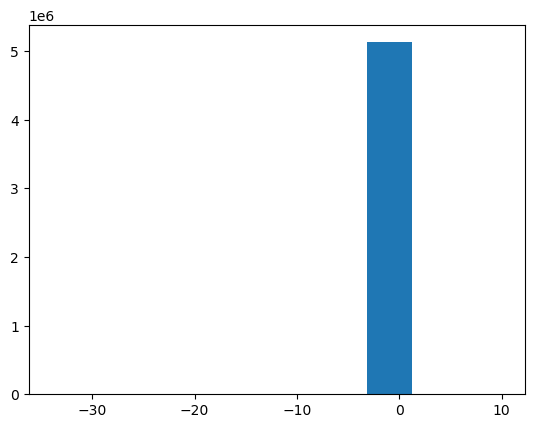

In [160]:
dataset = SyntheticSignalDataset(simulator, num_samples=samples_per_epoch)
train_ds = DataLoader(dataset, batch_size=batch_size, shuffle=True)

histo=[]
for step, batch in enumerate(train_ds):
    second_d = np.array(compute_second_derivative(jnp.array(batch[2])))
    histo.append(second_d[second_d!=0])
    
histo=np.concatenate(histo)
hist(histo)

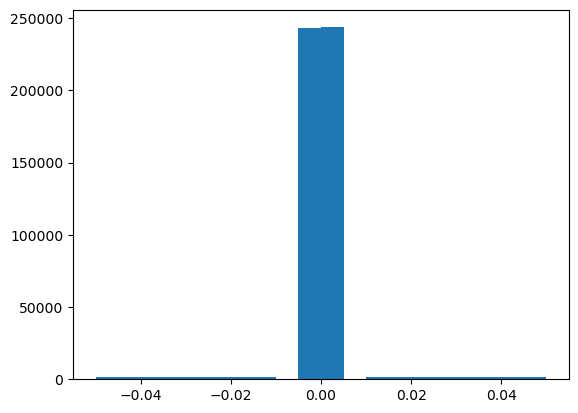

In [94]:
hist(histo[::10],range=[-0.05,0.05],bins=20);

In [8]:
dataset = SyntheticSignalDataset(simulator, num_samples=10000)
train_ds = DataLoader(dataset, batch_size=8, shuffle=True)

dataset2 = SyntheticSignalDataset(simulator, num_samples=20)
test_ds = DataLoader(dataset2, batch_size=8, shuffle=True)

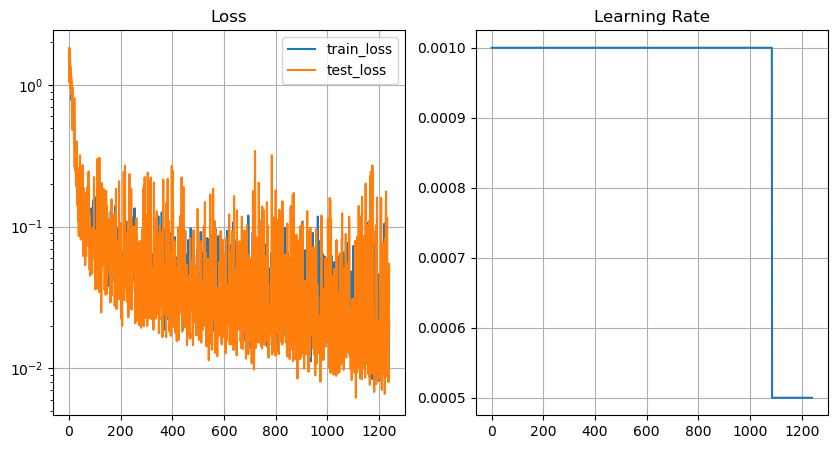

In [118]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
from optax import cosine_decay_schedule

metrics_history = {
    'train_loss': [],
    'test_loss': [],
    'learning_rate': [],  # Track learning rate
}

eval_every = 10
#train_steps = 10
num_epochs = 10
switch_epoch = num_epochs
samples_per_epoch = 10000
batch_size = 8

# Plateau detection parameters
plateau_patience = 200  # Number of evaluations to wait
plateau_factor = 0.5   # LR reduction factor
min_delta = 0.001      # Minimum improvement to count as progress

# Initialize plateau tracking
best_test_loss = float('inf')
plateau_count = 0
current_scale = 1.0  # Additional scaling factor

# Calculate total training steps
steps_per_epoch = samples_per_epoch // batch_size
total_steps = num_epochs * steps_per_epoch

# Base learning rate schedule
base_learning_rate = 0.001
#base_learning_rate = 0.00001

current_lr = base_learning_rate
base_schedule = cosine_decay_schedule(
    init_value=base_learning_rate,
    decay_steps=total_steps
)

momentum = 0.9
optimizer = nnx.Optimizer(model, optax.adamw(
    lambda step: base_learning_rate * current_scale,
    momentum
))

log_cosh = False
for epoch in range(num_epochs):
    dataset = SyntheticSignalDataset(simulator, num_samples=samples_per_epoch)
    train_ds = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    if switch_epoch==epoch:
        log_cosh=True
    for step, batch in enumerate(train_ds):
        global_step = epoch * steps_per_epoch + step  # Track global step
        
        batch = (jnp.array(batch[0]), jnp.array(batch[1]), jnp.array(batch[2]))
        train_step(model, optimizer, metrics, batch,log_cosh)

        if step > 0 and step % eval_every == 0:
            # Log training metrics
            train_metrics = metrics.compute()
            for metric, value in train_metrics.items():
                metrics_history[f'train_{metric}'].append(value)
            metrics.reset()

            # Evaluate on test set
            for test_batch in test_ds:
                test_batch = (jnp.array(test_batch[0]), jnp.array(test_batch[1]), jnp.array(test_batch[2]))
                eval_step(model, metrics, test_batch)

            # Log test metrics
            test_metrics = metrics.compute()
            test_loss = test_metrics['loss']
            metrics_history['test_loss'].append(test_loss)
            metrics.reset()

            # Track learning rate
            metrics_history['learning_rate'].append(current_lr)

            # Plateau detection
            if test_loss < (best_test_loss - min_delta):
                best_test_loss = test_loss
                plateau_count = 0
            else:
                plateau_count += 1

            # Reduce LR on plateau
            if plateau_count >= plateau_patience:
                current_scale *= plateau_factor
                plateau_count = 0
                print(f"\nReducing learning rate by {plateau_factor}x. New scale: {current_scale}")

                # Recreate optimizer with new scale
                optimizer = nnx.Optimizer(model, optax.adamw(
                    lambda step: base_learning_rate * current_scale,
                    momentum
                ))
                current_lr = base_learning_rate * current_scale


            # Visualization
            clear_output(wait=True)
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
            
            # Loss plot
            ax1.set_title('Loss')
            for dataset in ('train', 'test'):
                ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
            ax1.legend()
            ax1.set_yscale("log")
            ax1.grid()
            
            # Learning rate plot
            ax2.set_title('Learning Rate')
            ax2.plot(metrics_history['learning_rate'])
            ax2.grid()
            
            # Accuracy plot (if available)
            #ax3.set_title('Accuracy')
            # Add accuracy plotting logic here
            plt.show()

In [277]:
#metrics_history

# training with Peace wise linear activation , only 10 positions (coarse_bin=10)

In [116]:
dataset="train"
metrics_history[f'{dataset}_loss']

[Array(7.310857e+10, dtype=float32),
 Array(1.144785e+11, dtype=float32),
 Array(1.0354735e+11, dtype=float32),
 Array(1.1087243e+11, dtype=float32),
 Array(1.1031743e+11, dtype=float32),
 Array(1.101157e+11, dtype=float32),
 Array(1.0389837e+11, dtype=float32),
 Array(1.0740826e+11, dtype=float32),
 Array(1.0384027e+11, dtype=float32),
 Array(1.0674066e+11, dtype=float32),
 Array(1.0798971e+11, dtype=float32),
 Array(1.00466426e+11, dtype=float32),
 Array(1.1247316e+11, dtype=float32),
 Array(1.0413013e+11, dtype=float32),
 Array(1.0631638e+11, dtype=float32),
 Array(1.063145e+11, dtype=float32),
 Array(1.01900394e+11, dtype=float32),
 Array(1.0637654e+11, dtype=float32),
 Array(1.0738276e+11, dtype=float32),
 Array(1.06993525e+11, dtype=float32),
 Array(1.0951307e+11, dtype=float32),
 Array(1.0498119e+11, dtype=float32),
 Array(1.0639698e+11, dtype=float32),
 Array(1.022182e+11, dtype=float32),
 Array(9.954283e+10, dtype=float32),
 Array(1.0597538e+11, dtype=float32),
 Array(1.060178

In [46]:
import pickle
name="/home/jarbona/clara/BT2_0HU_RefBT1multi_analysis_mod_mappings.pickle"
with open(name,"rb") as f:
    data = pickle.load(f)

(array([7.726e+03, 2.985e+03, 1.458e+03, 5.950e+02, 2.080e+02, 7.600e+01,
        2.600e+01, 7.000e+00, 1.000e+00, 1.000e+00]),
 array([ 100. ,  291.5,  483. ,  674.5,  866. , 1057.5, 1249. , 1440.5,
        1632. , 1823.5, 2015. ]),
 <BarContainer object of 10 artists>)

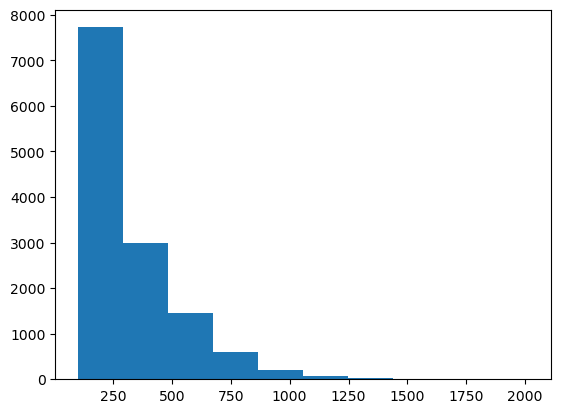

In [51]:
k0 = list(data.keys())[0]
sizel = [  len(data[k0][1]["B"]) for k0 in data.keys()]
hist(sizel)

(8, 1000) (8, 1000)
(8, 1000) (8, 1000)
(4, 1000) (4, 1000)


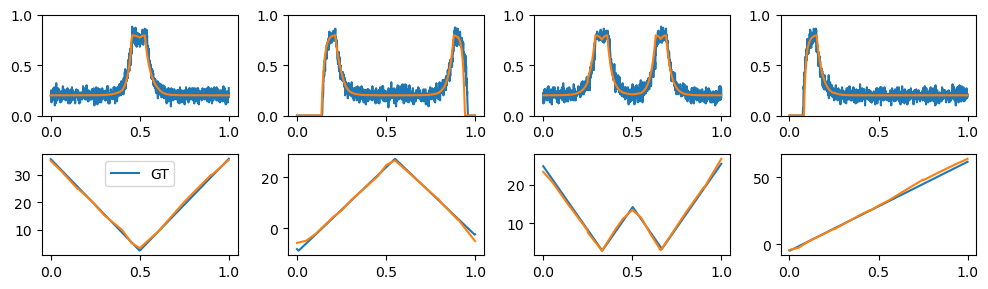

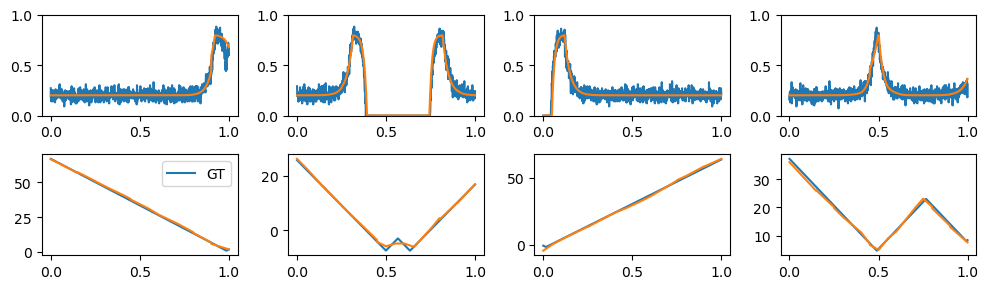

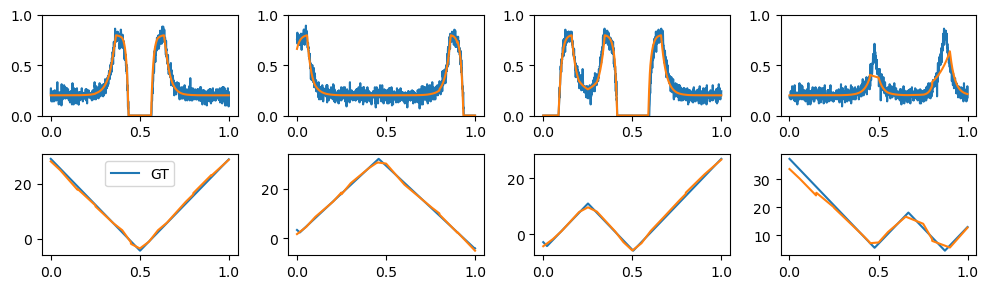

In [126]:
n=0
for test_batch in test_ds:
    x_test = jnp.array(test_batch[0])
    noisy_transformed = jnp.array(test_batch[1])
    res = model(noisy_transformed, x_test)
    #print(noisy_transformed.shape, x_test.shape)
    y_pred=res["activation"]
    gt = jnp.array(test_batch[2])
    tem = model.mlp(y_pred)
    #x_coarse = model.activation_layer.coarse_positions(tem)
    # Plot results


    fig,ax = subplots(2,4,figsize=(10, 3))
    #suptitle("Replication like")
    for i in range(4):
        #for j in range(2):
        #j=0
        display=i
        ax[0,i].plot(x_test[display], noisy_transformed[display,...]) 
        ax[0,i].plot(x_test[display], transform(y_pred[display,...])) 

        ax[0,i].set_ylim(0,1)
        #ax[1,i].plot(x_test[display],gt[display],"-",label="GT")
        ax[1,i].plot(x_test[display],gt[display],"-",label="GT")
        ax[1,i].plot(x_test[display], y_pred[display,...]) 
        #print(y_pred[display,...]) 
    ax[1,0].legend()
    fig.tight_layout()
    n+=1
    if n == 4:
        break
    

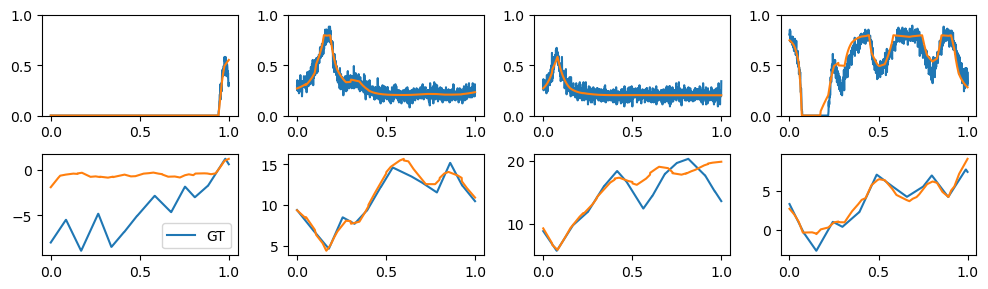

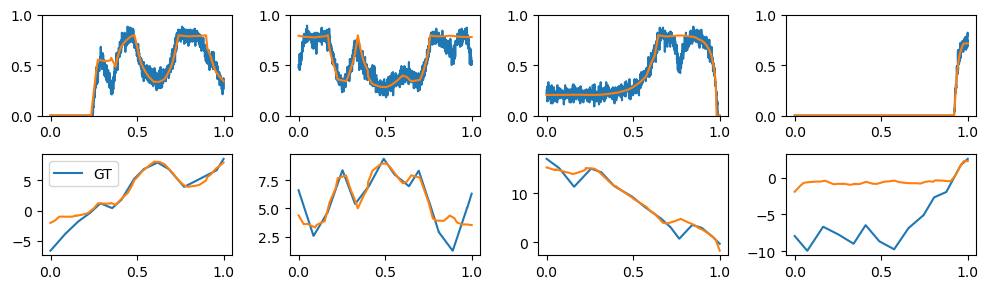

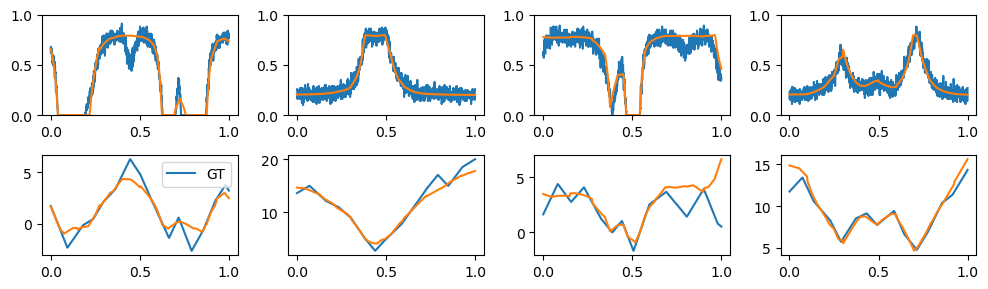

In [44]:
n=0
for test_batch in test_ds:
    x_test = jnp.array(test_batch[0])
    noisy_transformed = jnp.array(test_batch[1])
    res = model(noisy_transformed, x_test)
    y_pred=res["activation"]
    gt = jnp.array(test_batch[2])
    tem = model.mlp(y_pred)
    #x_coarse = model.activation_layer.coarse_positions(tem)
    # Plot results


    fig,ax = subplots(2,4,figsize=(10, 3))
    #suptitle("Replication like")
    for i in range(4):
        #for j in range(2):
        #j=0
        display=i
        ax[0,i].plot(x_test[display], noisy_transformed[display,...]) 
        ax[0,i].plot(x_test[display], transform(y_pred[display,...])) 

        ax[0,i].set_ylim(0,1)
        #ax[1,i].plot(x_test[display],gt[display],"-",label="GT")
        ax[1,i].plot(x_test[display],gt[display],"-",label="GT")
        ax[1,i].plot(x_test[display], y_pred[display,...]) 
        #print(y_pred[display,...]) 
    ax[1,0].legend()
    fig.tight_layout()
    n+=1
    if n == 4:
        break
    

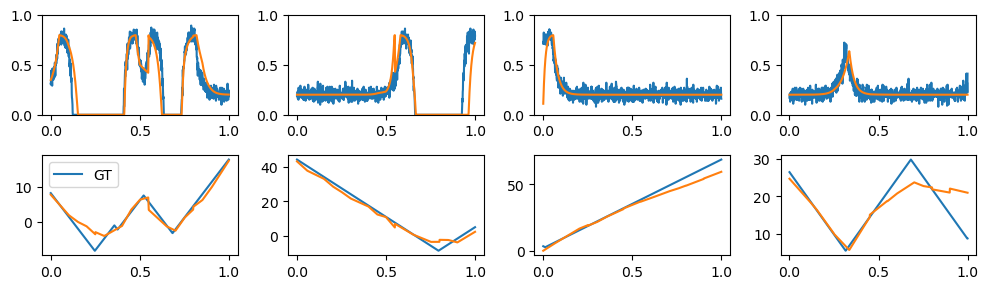

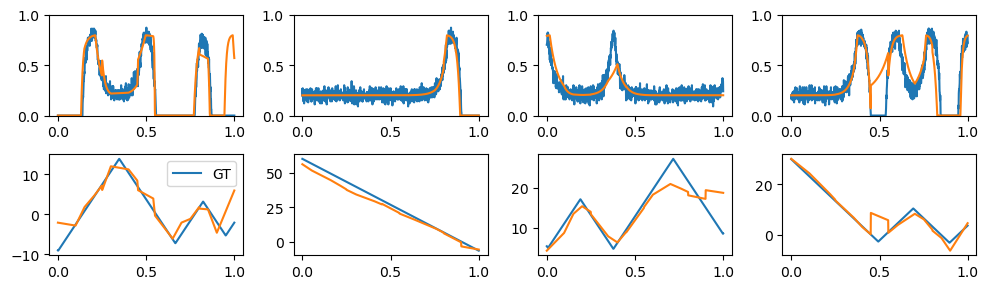

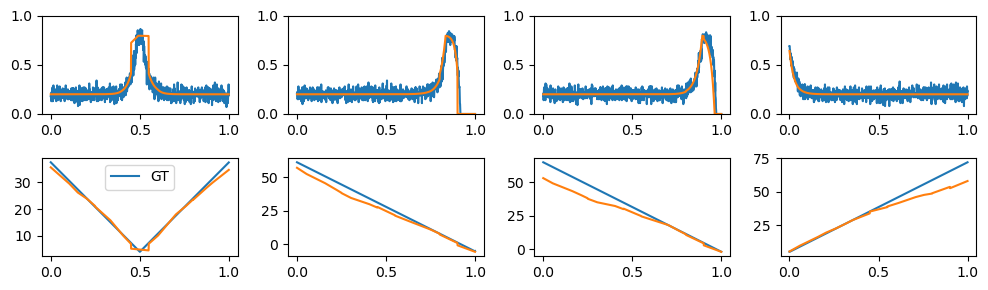

In [20]:
n=0
for test_batch in test_ds:
    x_test = jnp.array(test_batch[0])
    noisy_transformed = jnp.array(test_batch[1])
    res = model(noisy_transformed, x_test)
    y_pred=res["activation"]
    gt = jnp.array(test_batch[2])
    tem = model.mlp(y_pred)
    #x_coarse = model.activation_layer.coarse_positions(tem)
    # Plot results


    fig,ax = subplots(2,4,figsize=(10, 3))
    #suptitle("Replication like")
    for i in range(4):
        #for j in range(2):
        #j=0
        display=i
        ax[0,i].plot(x_test[display], noisy_transformed[display,...]) 
        ax[0,i].plot(x_test[display], transform(y_pred[display,...])) 

        ax[0,i].set_ylim(0,1)
        #ax[1,i].plot(x_test[display],gt[display],"-",label="GT")
        ax[1,i].plot(x_test[display],gt[display],"-",label="GT")
        ax[1,i].plot(x_test[display], y_pred[display,...]) 
        #print(y_pred[display,...]) 
    ax[1,0].legend()
    fig.tight_layout()
    n+=1
    if n == 4:
        break
    

# With replication-like model (Takes more time)

Array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

In [37]:
import numpy as np
import jax.random as rnd
import jax.numpy as jnp
from pylab import *
from flax import nnx
import jax
import optax

from universal_inverter.activations import ReplicationActivation,PiecewiseLinear


class MLP(nnx.Module):
    def __init__(self, din: int, hidden_dim: int, coarse_bins: int, *, rngs: nnx.Rngs):
        
        self.coarse_bins = coarse_bins
        self.linear1 = nnx.Linear(din, hidden_dim, rngs=rngs)
        self.linear2 = nnx.Linear(hidden_dim, coarse_bins * 2, rngs=rngs)
        self.speed = nnx.Linear(hidden_dim, 1, rngs=rngs)


    def __call__(self, x: jax.Array):
        intermediary = nnx.relu(self.linear1(x))
        return self.linear2(intermediary).reshape(-1,self.coarse_bins,2), \
                nnx.relu(self.speed(intermediary))
    

class Model(nnx.Module):

    def __init__(self, din: int, hidden_dim: int = 512, coarse_bins: int = 16, *, rngs: nnx.Rngs):
        
        self.coarse_bins=coarse_bins
        self.mlp = MLP(din,hidden_dim, self.coarse_bins,rngs=rngs)
        self.activation_layer = ReplicationActivation(self.coarse_bins, xmin=0, xmax=1)

    def __call__(self, y_batch, x_eval_batch):
        # y_batch shape: (batch, num_points)
        # x_eval_batch shape: (batch, eval_points)
        params,speed = self.mlp(y_batch)  # (batch, coarse_bins, 3)
        #print(params.shape,x_eval_batch.shape)
        #print(params.shape)
        #print(x_eval_batch.shape)
        # Evaluate each function's control points at corresponding x_eval
        return self.activation_layer(params,speed, x_eval_batch)

    
key = jax.random.PRNGKey(0)
y_batch = activations
x_eval_batch = fine_grid
target_batch = y_batch  # (2, 100)


# Initialize model
model = Model(1000,coarse_bins=16,rngs=nnx.Rngs(2))

def loss_fn(model, y_batch, x_eval, target_batch):
    preds = model(y_batch, x_eval)  # preds shape (2, 100)
    #print(preds.shape,target_batch.shape)
    return jnp.mean((preds - target_batch) ** 2)


learning_rate = 0.001
momentum = 0.9

optimizer = nnx.Optimizer(model, optax.adamw(learning_rate, momentum))

# Training loop with corrected batching
epochs = 10000
for epoch in range(epochs):
    #grads = jax.grad(loss_fn)(params, y_batch, x_eval_batch, target_batch)
    #updates, opt_state = tx.update(grads, opt_state)
    #params = optax.apply_updates(params, updates)
    
    
    grad_fn = nnx.value_and_grad(loss_fn)
    loss, grads = grad_fn(model,  y_batch, x_eval_batch, target_batch)
    #metrics.update(loss=loss, logits=logits, labels=batch['label'])  # In-place updates.
    optimizer.update(grads)  # In-place updates.
    
    if epoch % 50 == 0:
        #total_loss = loss_fn(params, y_batch, x_eval_batch, target_batch)
        print(f"Epoch {epoch}, Total Loss: {loss:.6f}")

Epoch 0, Total Loss: 2135751393280.000000
Epoch 50, Total Loss: 0.654673
Epoch 100, Total Loss: 0.421365
Epoch 150, Total Loss: 0.177682
Epoch 200, Total Loss: 0.050053
Epoch 250, Total Loss: 0.020972
Epoch 300, Total Loss: 0.014969
Epoch 350, Total Loss: 0.013044
Epoch 400, Total Loss: 0.012111
Epoch 450, Total Loss: 0.011546
Epoch 500, Total Loss: 0.011157
Epoch 550, Total Loss: 0.010862
Epoch 600, Total Loss: 0.010627
Epoch 650, Total Loss: 0.010432
Epoch 700, Total Loss: 0.010265
Epoch 750, Total Loss: 0.010112
Epoch 800, Total Loss: 0.009965
Epoch 850, Total Loss: 0.009830
Epoch 900, Total Loss: 0.009675
Epoch 950, Total Loss: 0.009542
Epoch 1000, Total Loss: 0.009423
Epoch 1050, Total Loss: 0.009305
Epoch 1100, Total Loss: 0.009170
Epoch 1150, Total Loss: 0.009050
Epoch 1200, Total Loss: 0.008834
Epoch 1250, Total Loss: 0.008656
Epoch 1300, Total Loss: 0.008575
Epoch 1350, Total Loss: 0.008502
Epoch 1400, Total Loss: 0.008215
Epoch 1450, Total Loss: 0.008115
Epoch 1500, Total Los

<Figure size 1000x500 with 0 Axes>

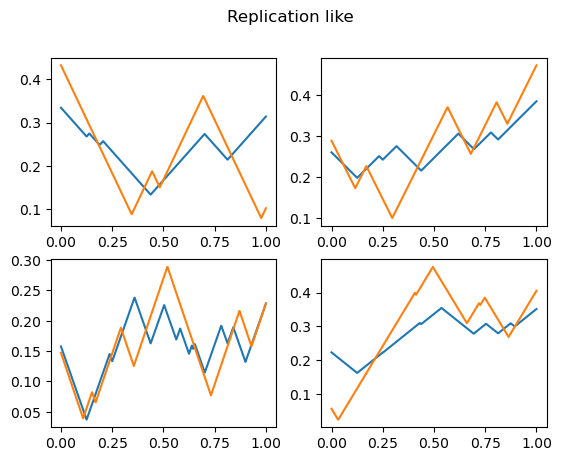

In [40]:
# Test and plot results

# Predict
#app = lambda y :model.apply(params, y, x_test)
x_test = x_eval_batch
y_pred = model(y_batch, x_eval_batch)
tem,speed = model.mlp(y_pred)
x_coarse = model.activation_layer.coarse_positions(tem)
# Plot results
plt.figure(figsize=(10, 5))


fig,ax = subplots(2,2)
suptitle("Replication like")
for i in range(2):
    for j in range(2):
        display=i*2+j
        ax[i,j].plot(x_test[display], y_pred[display,...]) 
        ax[i,j].plot(x_test[display],y_batch[display],"-")
    

# Easier at lower resolution

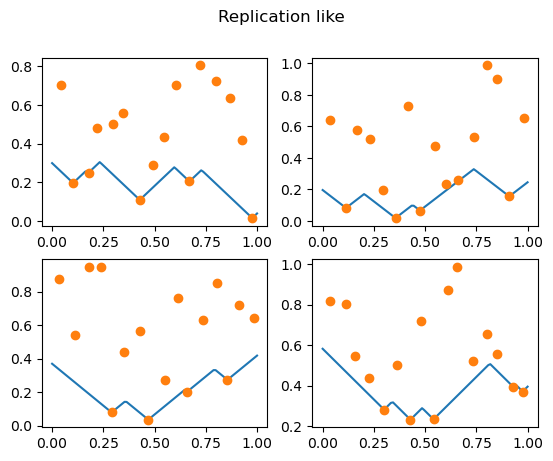

In [41]:
batch = 8
fork_speed = 1
coarse_bins = 16 

rng = rnd.PRNGKey(0)

layer = ReplicationActivation(
    coarse_bins=coarse_bins,
    xmin=0.0,
    xmax=1.0
)
inputs = np.random.rand(batch, coarse_bins ,2)

inputs = jnp.array(inputs)
fine_grid =  jnp.repeat(jnp.linspace(0, 1, 100)[None,:],batch,axis=0)

speed = jnp.stack([fork_speed]*batch)[:,None]
activations = layer(inputs,speed,fine_grid)  # Shape: (8, 1024)

#Get position of coarse grained points
grid_positions = layer.coarse_positions(inputs)

fig,ax = subplots(2,2)
suptitle("Replication like")
for i in range(2):
    for j in range(2):
        display=i*2+j
        ax[i,j].plot(fine_grid[0],activations[display]) 
        ax[i,j].plot(grid_positions[display],inputs[display][:,1],"o")

In [44]:
import numpy as np
import jax.random as rnd
import jax.numpy as jnp
from pylab import *
from flax import nnx
import jax
import optax

from universal_inverter.activations import ReplicationActivation,PiecewiseLinear


class MLP(nnx.Module):
    def __init__(self, din: int, hidden_dim: int, coarse_bins: int, *, rngs: nnx.Rngs):
        
        self.coarse_bins = coarse_bins
        self.linear1 = nnx.Linear(din, hidden_dim, rngs=rngs)
        self.linear2 = nnx.Linear(hidden_dim, coarse_bins * 2, rngs=rngs)
        self.speed = nnx.Linear(hidden_dim, 1, rngs=rngs)


    def __call__(self, x: jax.Array):
        intermediary = nnx.relu(self.linear1(x))
        return self.linear2(intermediary).reshape(-1,self.coarse_bins,2), \
                nnx.relu(self.speed(intermediary))
    

class Model(nnx.Module):

    def __init__(self, din: int, hidden_dim: int = 512, coarse_bins: int = 16, *, rngs: nnx.Rngs):
        
        self.coarse_bins=coarse_bins
        self.mlp = MLP(din,hidden_dim, self.coarse_bins,rngs=rngs)
        self.activation_layer = ReplicationActivation(self.coarse_bins, xmin=0, xmax=1)

    def __call__(self, y_batch, x_eval_batch):
        # y_batch shape: (batch, num_points)
        # x_eval_batch shape: (batch, eval_points)
        params,speed = self.mlp(y_batch)  # (batch, coarse_bins, 3)
        #print(params.shape,x_eval_batch.shape)
        #print(params.shape)
        #print(x_eval_batch.shape)
        # Evaluate each function's control points at corresponding x_eval
        return self.activation_layer(params,speed, x_eval_batch)

    
key = jax.random.PRNGKey(0)
y_batch = activations
x_eval_batch = fine_grid
target_batch = y_batch  # (2, 100)


# Initialize model
model = Model(100,coarse_bins=8,rngs=nnx.Rngs(2))

def loss_fn(model, y_batch, x_eval, target_batch):
    preds = model(y_batch, x_eval)  # preds shape (2, 100)
    #print(preds.shape,target_batch.shape)
    return jnp.mean((preds - target_batch) ** 2)


learning_rate = 0.001
momentum = 0.9

optimizer = nnx.Optimizer(model, optax.adamw(learning_rate, momentum))

# Training loop with corrected batching
epochs = 1000
for epoch in range(epochs):
    #grads = jax.grad(loss_fn)(params, y_batch, x_eval_batch, target_batch)
    #updates, opt_state = tx.update(grads, opt_state)
    #params = optax.apply_updates(params, updates)
    
    
    grad_fn = nnx.value_and_grad(loss_fn)
    loss, grads = grad_fn(model,  y_batch, x_eval_batch, target_batch)
    #metrics.update(loss=loss, logits=logits, labels=batch['label'])  # In-place updates.
    optimizer.update(grads)  # In-place updates.
    
    if epoch % 50 == 0:
        #total_loss = loss_fn(params, y_batch, x_eval_batch, target_batch)
        print(f"Epoch {epoch}, Total Loss: {loss:.6f}")

Epoch 0, Total Loss: 3551212339200.000000
Epoch 50, Total Loss: 0.033451
Epoch 100, Total Loss: 0.009166
Epoch 150, Total Loss: 0.004627
Epoch 200, Total Loss: 0.002985
Epoch 250, Total Loss: 0.002108
Epoch 300, Total Loss: 0.001539
Epoch 350, Total Loss: 0.001205
Epoch 400, Total Loss: 0.001000
Epoch 450, Total Loss: 0.000862
Epoch 500, Total Loss: 0.000756
Epoch 550, Total Loss: 0.000672
Epoch 600, Total Loss: 0.000613
Epoch 650, Total Loss: 0.000569
Epoch 700, Total Loss: 0.000533
Epoch 750, Total Loss: 0.000502
Epoch 800, Total Loss: 0.000475
Epoch 850, Total Loss: 0.000452
Epoch 900, Total Loss: 0.000432
Epoch 950, Total Loss: 0.000410


<Figure size 1000x500 with 0 Axes>

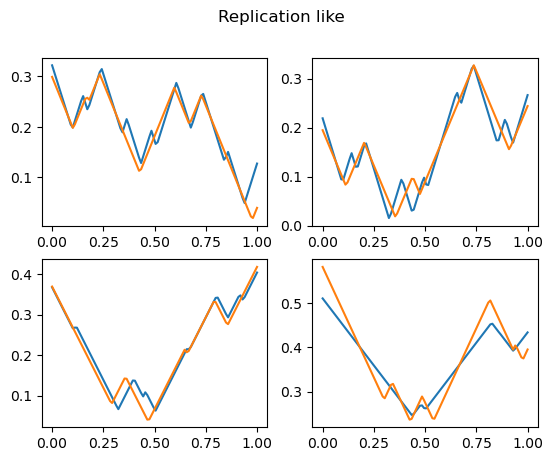

In [45]:
# Test and plot results

# Predict
#app = lambda y :model.apply(params, y, x_test)
x_test = x_eval_batch
y_pred = model(y_batch, x_eval_batch)
tem,speed = model.mlp(y_pred)
x_coarse = model.activation_layer.coarse_positions(tem)
# Plot results
plt.figure(figsize=(10, 5))


fig,ax = subplots(2,2)
suptitle("Replication like")
for i in range(2):
    for j in range(2):
        display=i*2+j
        ax[i,j].plot(x_test[display], y_pred[display,...]) 
        ax[i,j].plot(x_test[display],y_batch[display],"-")
    